Burgers equation is

$$
\frac{\delta u}{\delta t} + u\frac{\delta u}{\delta x} = v\frac{\delta^2 u}{\delta x^2}
$$
where

$$
x \in [-1,1]
$$

and 
$$
t \in [0,1]
$$

There are 4 parameters in Burgers' equation: 
$u, t, x$ and $\nu$. In a system consisting of a moving viscous fluid with one spatial $x$ and one temporal $t$ dimension, e.g. a thin ideal pipe with fluid running through it, Burgers' equation describes the speed of the fluid at each location along the pipe as time progresses. 

 - $x$: spatial coordinate
 - $t$: temporal coordinate
 - $u(x,t)$: speed of fluid at the indicated spatial and temporal coordinates
 - $\nu$ : viscosity of fluid
The viscosity is a constant physical property of the fluid, and the other parameters represent the dynamics contingent on that viscosity.

# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
device = 'cpu'

# Parameters

In [2]:
steps=10000
lr=1e-1
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
N_u = 100 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 
NU = 0.01/np.pi #diffusion coeficient

# Exploring the true solution

Burgers' equation doesn't have a close form solution. Thus we must integrate in order to get a picture of the correct solution. Integrating a PDE is pretty tough  - so we will just get the solution from the data

In [3]:
true_result=scipy.io.loadmat('Burgers.mat')
u_true = true_result['usol']
t = true_result['t']
x = true_result['x']

Text(0, 0.5, 'x')

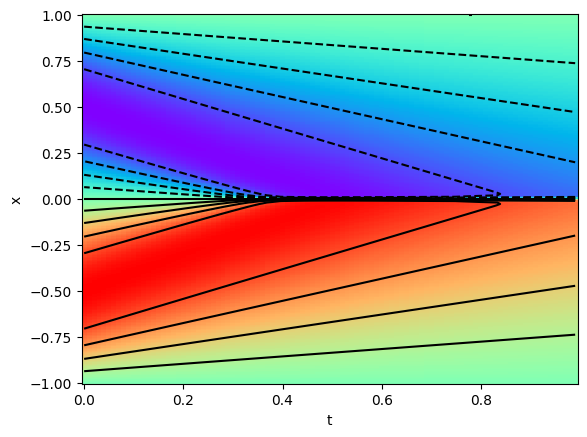

In [4]:
tt,xx = np.meshgrid(t.squeeze(),x.squeeze())
plt.pcolormesh( tt,xx, u_true,cmap='rainbow')
plt.contour(tt,xx, u_true, 10, colors='k')
plt.xlabel("t")
plt.ylabel('x')

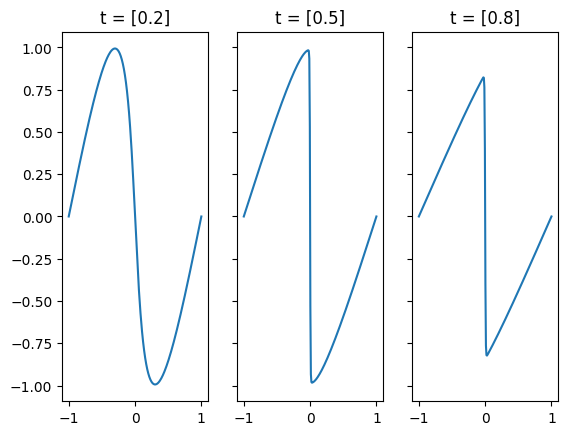

In [5]:
# Lets visualise this on a plot where time is a diffeerent line
f, ax = plt.subplots(1, 3, sharey=True)
t_index = [20,50,80]
for i in range(len(t_index)):
    ax[i].plot(x, u_true[:,t_index[i]])
    ax[i].set_title(f't = {t[t_index[i]]}')

As we can see, as time increases, the shockwave increases

## Training the NN

In [6]:
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

In [7]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers
        self.activation =nn.Tanh()
        self.loss_function = nn.MSELoss(reduction= 'mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
    
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        return self.linears[-1](a) # This one is outside of the loop, otherwise you would be applying an activation
    
    def lossBC(self,x_bc,y_bc):
        # x is the inputs (i.e. x,t pairs)
        # y is the expected output
        loss_bc = self.loss_function(self.forward(x_bc),y_bc)
        return loss_bc
    
    def lossPDE(self,x_pde):
        g = x_pde.clone()
        g.requires_grad = True # Not sure why we need to enable grad on the data??
        f = self.forward(g)
        f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]),retain_graph = True, create_graph = True)[0] # First derivative
        f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape), create_graph=True)[0]#second derivative
        f_t = f_x_t[:,[1]]
        f_xx = f_xx_tt[:,[0]]
        f_x = f_x_t[:,[0]]
        f = f_t + f*f_x - NU*f_xx
        return self.loss_function(f,f_hat)
    
    def loss(self,x_bc,y_bc,x_pde):
        return self.lossPDE(x_pde) + self.lossBC(x_bc,y_bc)
    
    def closure(self):
        
        optimizer.zero_grad()    
        loss = self.loss(X_train_Nb, Y_train_Nb, X_train_Nf)
        loss.backward()
                
        self.iter += 1
        if self.iter % 100 == 0:
            error_vec, _ = PINN.test()
            print(loss,error_vec)
        return loss       
    
    def test(self):
        with torch.no_grad():
            u_pred = self.forward(X_test)
            error_vec = torch.linalg.norm((Y_test-u_pred),2)/torch.linalg.norm(Y_test,2)   # Relative L2 Norm of the error (Vector)
            u_pred = u_pred.cpu().detach().numpy()
            u_pred = np.reshape(u_pred,(256,100),order='F')
        return error_vec, u_pred
    

# Preparing the data

In [8]:
Nb=100 # number of boundary condition points
Nf=1000 # number of collocation points
from pyDOE import lhs         #Latin Hypercube Sampling

In [9]:
# Now let's prepare the data 

# First flatten the training data (collocation points) and create a test vector
x_test = torch.hstack((torch.from_numpy(xx.transpose(1,0).flatten()[:,None]),
                       torch.from_numpy(tt.transpose(1,0).flatten()[:,None])))
y_test = torch.from_numpy(u_true.transpose(1,0).flatten()[:,None])
lb = x_test[0]
ub = x_test[-1]

In [10]:
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t

In [11]:
initial_x = xx[:,0].squeeze()[:,None]
initial_t = tt[:,0].squeeze()[:,None]
inital_u = u_true[:,0].squeeze()[:,None]

top_x = xx[0,:].squeeze()[:,None]
top_t = tt[0,:].squeeze()[:,None]
top_u = u_true[0,:].squeeze()[:,None]

bottom_x = xx[-1,:].squeeze()[:,None]
bottom_t = tt[-1,:].squeeze()[:,None]
bottom_u = u_true[-1,:].squeeze()[:,None]

x_b = np.concatenate([initial_x,top_x,bottom_x],axis = 0)
t_b = np.concatenate([initial_t,top_t,bottom_t],axis = 0)
u_b = np.concatenate([inital_u,top_u,bottom_u],axis = 0)

X_train_Nb = torch.hstack((torch.from_numpy(x_b),torch.from_numpy(t_b)) )
Y_train_Nb = torch.from_numpy(u_b)

idx = np.random.choice(X_train_Nb.shape[0],Nb,replace=False)

X_train_Nb = X_train_Nb[idx]
Y_train_Nb = Y_train_Nb[idx]

In [12]:
X_train_Nb=X_train_Nb.float()
Y_train_Nb=Y_train_Nb.float()
X_train_Nf=X_train_Nf.float()
f_hat = torch.zeros(X_train_Nf.shape[0],1)

X_test=x_test.float() # the input dataset (complete)
Y_test=y_test.float() # the real solution 

In [13]:
# Create the model
steps=10000
lr=0.1
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = FCN(layers)
#optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)

optimizer = torch.optim.LBFGS(PINN.parameters(), lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
optimizer.step(PINN.closure)

tensor(0.1077, grad_fn=<AddBackward0>) tensor(0.5702)
tensor(0.0731, grad_fn=<AddBackward0>) tensor(0.5191)
tensor(0.0493, grad_fn=<AddBackward0>) tensor(0.3853)
tensor(0.0244, grad_fn=<AddBackward0>) tensor(0.3055)
tensor(0.0146, grad_fn=<AddBackward0>) tensor(0.2907)
tensor(0.0081, grad_fn=<AddBackward0>) tensor(0.2738)
tensor(0.0047, grad_fn=<AddBackward0>) tensor(0.2576)
tensor(0.0030, grad_fn=<AddBackward0>) tensor(0.2565)
tensor(0.0020, grad_fn=<AddBackward0>) tensor(0.2582)
tensor(0.0016, grad_fn=<AddBackward0>) tensor(0.2651)
tensor(0.0013, grad_fn=<AddBackward0>) tensor(0.2614)
tensor(0.0011, grad_fn=<AddBackward0>) tensor(0.2613)
tensor(0.0010, grad_fn=<AddBackward0>) tensor(0.2603)
tensor(0.0009, grad_fn=<AddBackward0>) tensor(0.2599)
tensor(0.0008, grad_fn=<AddBackward0>) tensor(0.2586)
tensor(0.0008, grad_fn=<AddBackward0>) tensor(0.2579)
tensor(0.0007, grad_fn=<AddBackward0>) tensor(0.2571)
tensor(0.0006, grad_fn=<AddBackward0>) tensor(0.2546)
tensor(0.0006, grad_fn=<AddB

tensor(0.4081, grad_fn=<AddBackward0>)

In [14]:
y1=PINN(X_test)
x1=X_test[:,0]
t1=X_test[:,1]

In [15]:
arr_x1=x1.reshape(shape=[100,256]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,256]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,256]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,256]).transpose(1,0).detach().cpu()

Text(0, 0.5, 'x')

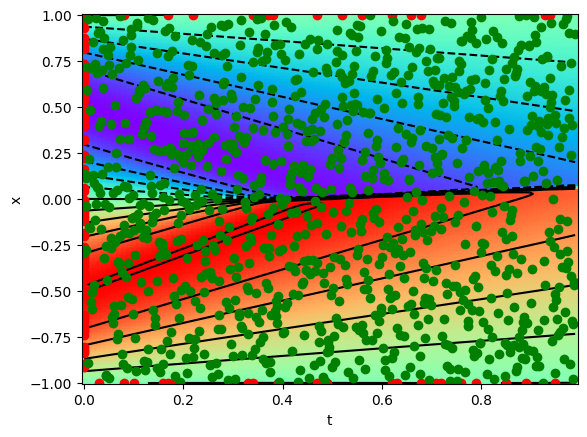

In [16]:
plt.pcolormesh(arr_T1, arr_x1, arr_y1,cmap='rainbow')
plt.contour(arr_T1, arr_x1, arr_y1, 10, colors='k')
plt.plot(X_train_Nb.detach().numpy()[:,1],X_train_Nb.detach().numpy()[:,0],'ro')
plt.plot(X_train_Nf.detach().numpy()[:,1],X_train_Nf.detach().numpy()[:,0],'go')
plt.xlabel("t")
plt.ylabel('x')

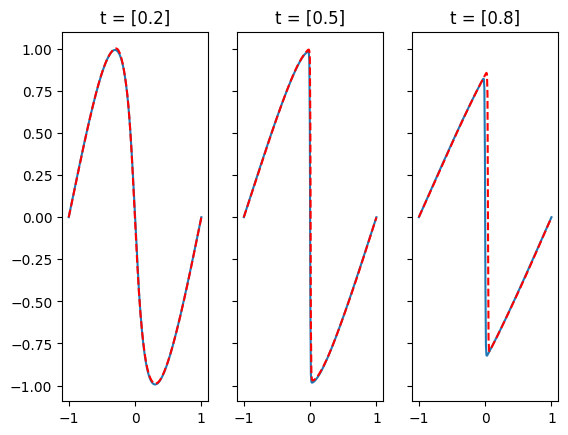

In [17]:
# Lets visualise this on a plot where time is a diffeerent line
f, ax = plt.subplots(1, 3, sharey=True)
t_index = [20,50,80]
for i in range(len(t_index)):
    ax[i].plot(x, u_true[:,t_index[i]])
    ax[i].plot(x, arr_y1[:,t_index[i]],'r--')
    ax[i].set_title(f't = {t[t_index[i]]}')

# Lets now extrapolate into the future

Using our newly trainged Neral network, let's now extrapolate into the future

In [18]:
def get_arr_for_plot(PINN,x,t):
    Nx = len(x)
    Nt = len(t)
    
    tt_extrap,xx_extrap = np.meshgrid(t,x)
    
    X_extrap = torch.hstack((torch.from_numpy(xx_extrap.flatten()[:,None]),torch.from_numpy(tt_extrap.flatten()[:,None])))
    Y_extrap=PINN(X_extrap)

    x1=X_extrap[:,0]
    t1=X_extrap[:,1]
    arr_x1=x1.reshape(shape=[Nx,Nt]).transpose(1,0).detach().cpu()
    arr_T1=t1.reshape(shape=[Nx,Nt]).transpose(1,0).detach().cpu()
    arr_y1=Y_extrap.reshape(shape=[Nx,Nt]).transpose(1,0).detach().cpu()
    
    return arr_x1,arr_T1,arr_y1

In [19]:
t_extrap = np.linspace(0,1.5,1000)
x_extrap = np.linspace(-1,1,100)
arr_x1,arr_T1,arr_y1 = get_arr_for_plot(PINN,x_extrap,t_extrap)

Text(0, 0.5, 'x')

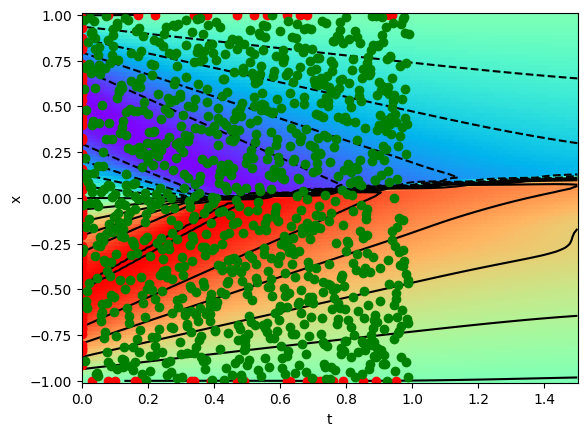

In [20]:
plt.pcolormesh(arr_T1, arr_x1, arr_y1,cmap='rainbow')
plt.contour(arr_T1, arr_x1, arr_y1, 10, colors='k')

plt.plot(X_train_Nb.detach().numpy()[:,1],X_train_Nb.detach().numpy()[:,0],'ro')
plt.plot(X_train_Nf.detach().numpy()[:,1],X_train_Nf.detach().numpy()[:,0],'go')

plt.xlabel("t")
plt.ylabel('x')

In [21]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

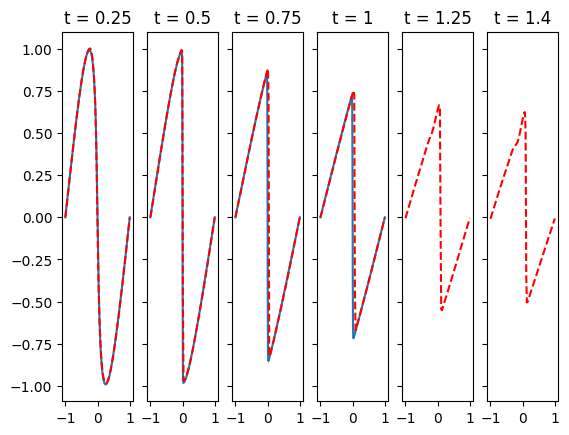

In [22]:
# Lets visualise this on a plot where time is a diffeerent line

t_target = [0.25,0.5,0.75,1,1.25,1.4]
f, ax = plt.subplots(1, len(t_target), sharey=True)
for i in range(len(t_target)):
    if (t_target[i] <= 1):
        _,t_index = find_nearest(true_result['t'],t_target[i])
        ax[i].plot(x, u_true[:,t_index])

    _,t_index = find_nearest(t_extrap,t_target[i])
    ax[i].plot(x_extrap, arr_y1[t_index,:],'r--')
    ax[i].set_title(f't = {t_target[i]}')

(-1.0, 1.0)

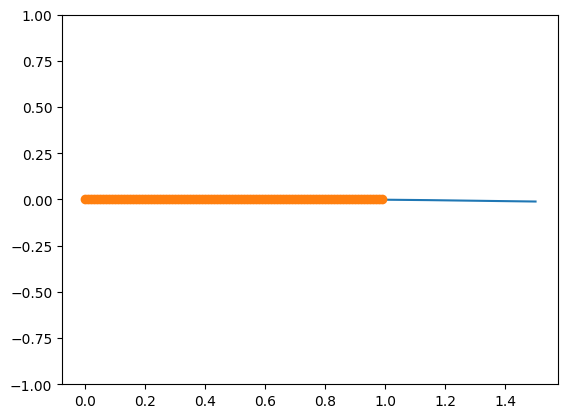

In [35]:
# Lets' also visualise the boundary condition

# Bottom boundary
plt.plot(arr_T1[:,0],arr_y1[:,0])
plt.plot(true_result['t'], u_true[0,:],'o')
plt.ylim(-1,1)

(-1.0, 1.0)

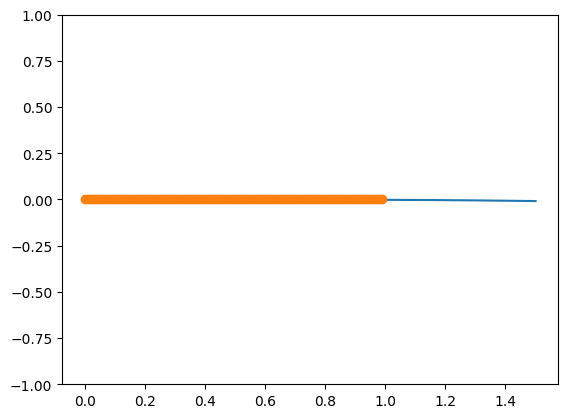

In [36]:

# Top boundary
plt.plot(arr_T1[:,-1],arr_y1[:,-1])
plt.plot(true_result['t'], u_true[-1,:],'o')
plt.ylim(-1,1)

In [25]:
arr_x1

tensor([[-1.0000, -0.9798, -0.9596,  ...,  0.9596,  0.9798,  1.0000],
        [-1.0000, -0.9798, -0.9596,  ...,  0.9596,  0.9798,  1.0000],
        [-1.0000, -0.9798, -0.9596,  ...,  0.9596,  0.9798,  1.0000],
        ...,
        [-1.0000, -0.9798, -0.9596,  ...,  0.9596,  0.9798,  1.0000],
        [-1.0000, -0.9798, -0.9596,  ...,  0.9596,  0.9798,  1.0000],
        [-1.0000, -0.9798, -0.9596,  ...,  0.9596,  0.9798,  1.0000]],
       dtype=torch.float64)